*Read section 8.2.1 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

## Bagging

Bagging, short for **Bootstrap Aggregating**, is an effective way to reduce overfitting in decision trees. It works by training multiple decision trees—each on a different bootstrap sample of the data—and then aggregating their predictions.

Each individual decision tree is a **weak learner** and prone to overfitting, but by combining many such trees, bagging produces a **strong learner** with **lower variance** and improved generalization performance.

The number of trees to include in the ensemble is specified by the `n_estimators` hyperparameter.

In [20]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.35)

# import the decision tree regressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import BaggingRegressor,BaggingClassifier

# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split


from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, KFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer, accuracy_score

## Bagging regression trees


Let's revisit the same dataset used for building a single regression tree and explore whether we can further improve its performance using bagging

In [25]:
# Load the dataset
car = pd.read_csv('Datasets/car.csv')
car.head()

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,vw,Beetle,2014,Manual,55457,Diesel,30,65.3266,1.6,7490
1,vauxhall,GTC,2017,Manual,15630,Petrol,145,47.2049,1.4,10998
2,merc,G Class,2012,Automatic,43000,Diesel,570,25.1172,3.0,44990
3,audi,RS5,2019,Automatic,10,Petrol,145,30.5593,2.9,51990
4,merc,X-CLASS,2018,Automatic,14000,Diesel,240,35.7168,2.3,28990


In [26]:
X = car.drop(columns=['price'])
y = car['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# extract the categorical columns and put them in a list
categorical_feature = X.select_dtypes(include=['object']).columns.tolist()

# extract the numerical columns and put them in a list
numerical_feature = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [27]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_encoded = encoder.fit_transform(X_train[categorical_feature])
X_test_encoded = encoder.transform(X_test[categorical_feature])

# Convert the encoded features back to DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_feature))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_feature))

# Concatenate the encoded features with the original numerical features
X_train_final = pd.concat([X_train_encoded_df, X_train[numerical_feature].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_encoded_df, X_test[numerical_feature].reset_index(drop=True)], axis=1)

Below is the [best model](https://lizhen0909.github.io/STAT303-3-class-notes/regression_tree_sp25.html#key-hyperparameters-in-decision-tree) obtained by tuning the hyperparameters of a single decision tree.

In [13]:
# fit the decision tree regressor
tree_reg = DecisionTreeRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=5, random_state=42)
tree_reg.fit(X_train_final, y_train)

# make predictions on the test set
y_pred = tree_reg.predict(X_test_final)
# calculate the RMSE and R^2 score
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print the RMSE and R^2 score, keep the decimal points to 2
print("Test RMSE:", round(rmse, 2))
print("Test R^2 score:", round(r2, 2))

Test RMSE: 4726.17
Test R^2 score: 0.92


Next, let's apply bagging to the optimized decision tree using 10 base estimators (default setting) and evaluate whether the performance improves.

In [28]:
#Bagging the results of 10 decision trees to predict car price
bagging_reg = BaggingRegressor(estimator=tree_reg, random_state=1,
                        n_jobs=-1).fit(X_train_final, y_train)

# make predictions on the test set
y_pred_bagging = bagging_reg.predict(X_test_final)

# calculate the RMSE and R^2 score
rmse_bagging = root_mean_squared_error(y_test, y_pred_bagging)
r2_bagging = r2_score(y_test, y_pred_bagging)

print("Test RMSE with Bagging pruned trees:", round(rmse_bagging, 2))
print("Test R^2 score with Bagging pruned trees:", round(r2_bagging, 2))


# training RMSE and R^2 score
y_pred_train_bagging = bagging_reg.predict(X_train_final)

# calculate the RMSE and R^2 score
rmse_train_bagging = root_mean_squared_error(y_train, y_pred_train_bagging)
r2_train_bagging = r2_score(y_train, y_pred_train_bagging)

print("Train RMSE with Bagging pruned trees:", round(rmse_train_bagging, 2))
print("Train R^2 score with Bagging pruned trees:", round(r2_train_bagging, 2))

Test RMSE with Bagging pruned trees: 3806.7
Test R^2 score with Bagging pruned trees: 0.95
Train RMSE with Bagging pruned trees: 1868.7
Train R^2 score with Bagging pruned trees: 0.99


Compared to the optimized single decision tree, bagging with pruned trees significantly improves performance—reducing the RMSE from 4726.17 to 3806.7 and increasing the R² score from 0.92 to 0.95.

Since bagging helps reduce variance, and the default setting for a single decision tree allows it to grow to full depth—often overfitting the training data—can we simply use the default tree as the base estimator for bagging?

In [30]:
#Bagging the results of 10 decision trees with the default parameters to predict car price
bagging_reg = BaggingRegressor(random_state=1, 
                        n_jobs=-1).fit(X_train_final, y_train)

# make predictions on the test set
y_pred_bagging = bagging_reg.predict(X_test_final)

# calculate the RMSE and R^2 score
rmse_bagging = root_mean_squared_error(y_test, y_pred_bagging)
r2_bagging = r2_score(y_test, y_pred_bagging)

print("Test RMSE with Bagging unpruned trees:", round(rmse_bagging, 2))
print("Test R^2 score with Bagging unpruned trees:", round(r2_bagging, 2))

# training RMSE and R^2 score
y_pred_train_bagging = bagging_reg.predict(X_train_final)

# calculate the RMSE and R^2 score
rmse_train_bagging = root_mean_squared_error(y_train, y_pred_train_bagging)
r2_train_bagging = r2_score(y_train, y_pred_train_bagging)

print("Train RMSE with Bagging unpruned trees:", round(rmse_train_bagging, 2))
print("Train R^2 score with Bagging unpruned trees:", round(r2_train_bagging, 2))

Test RMSE with Bagging unpruned trees: 3758.1
Test R^2 score with Bagging unpruned trees: 0.95
Train RMSE with Bagging unpruned trees: 1501.04
Train R^2 score with Bagging unpruned trees: 0.99


With the default setting, bagging using unpruned trees achieves an even lower RMSE of 3758.1 while maintaining the same R² score of 0.95.  
This suggests that when using bagging, we don’t necessarily need to tune the hyperparameters of the base decision tree—bagging itself effectively combats overfitting by reducing variance, much like hyperparameter tuning does.

## Model Performance vs. Number of Trees

To better understand how the number of base estimators affects the performance of a bagging model, we evaluate the test RMSE and R² score across different numbers of trees.  
This analysis helps us determine whether adding more trees continues to improve performance or if the model reaches a performance plateau.

c:\Users\lsi8012\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:1315: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
c:\Users\lsi8012\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:1315: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
c:\Users\lsi8012\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:1315: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(


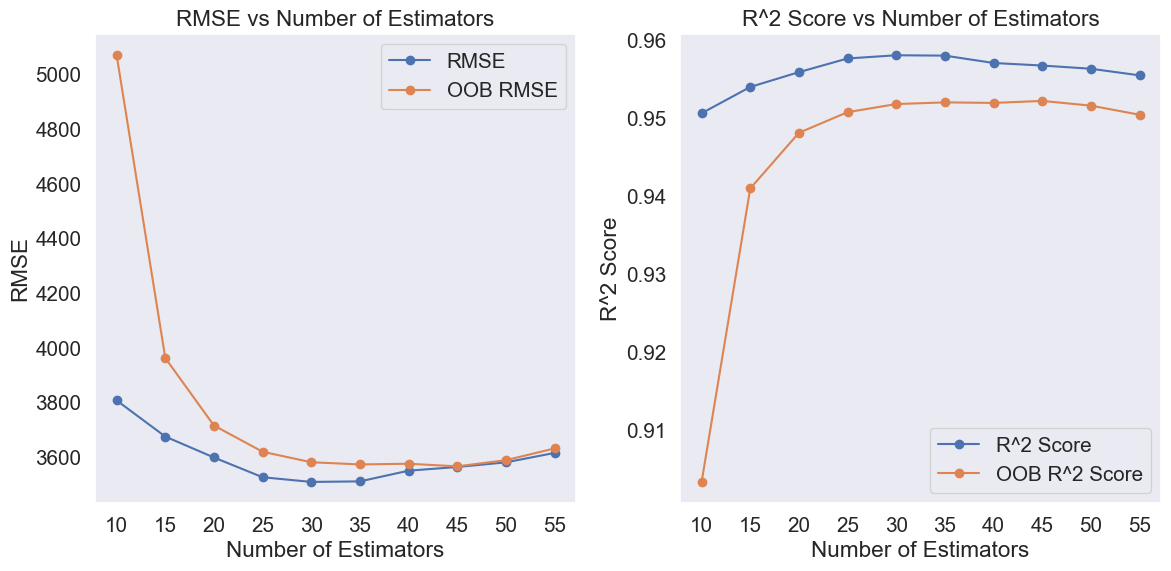

In [16]:
# explore how the number of estimators affects the performance of the model, output both oob and test scores
n_estimators = [ 10, 15, 20, 25,30, 35, 40, 45, 50, 55]
rmse_scores = []
r2_scores = []
oob_scores = []
oob_rmse_scores = []
# iterate through the number of estimators and fit the model
for n in n_estimators:
    bagging_reg = BaggingRegressor(estimator=tree_reg, n_estimators=n, oob_score=True, random_state=1,
                        n_jobs=-1).fit(X_train_final, y_train)
    y_pred_bagging = bagging_reg.predict(X_test_final)
    rmse_scores.append(np.sqrt(np.mean((y_test - y_pred_bagging) ** 2)))
    r2_scores.append(r2_score(y_test, y_pred_bagging))
    oob_scores.append(bagging_reg.oob_score_)
    oob_rmse_scores.append(np.sqrt(np.mean((y_train - bagging_reg.oob_prediction_) ** 2)))

# plot the RMSE and R^2 scores against the number of estimators
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(n_estimators, rmse_scores, marker='o')
plt.plot(n_estimators, oob_rmse_scores, marker='o')
plt.legend(['RMSE', 'OOB RMSE'])
plt.title('RMSE vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.xticks(n_estimators)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(n_estimators, r2_scores, marker='o')
plt.plot(n_estimators, oob_scores, marker='o')
plt.legend(['R^2 Score', 'OOB R^2 Score'])
plt.title('R^2 Score vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2 Score')
plt.xticks(n_estimators)
plt.grid()
plt.tight_layout()
plt.show()


**Quick Takeaway**

- **Increasing the number of estimators improves performance initially**, as shown by the decreasing RMSE and increasing R² scores on both the test set and OOB estimates.
- **Performance stabilizes around 30–35 estimators**, beyond which further increases lead to minimal gains.
- **OOB estimates become more reliable** as the number of trees grows, with OOB scores closely tracking the test performance after around 30 estimators.
- **OOB RMSE is consistently higher** and **OOB R² is consistently lower** than their test counterparts when the ensemble is small, highlighting the **instability of OOB estimates with few trees**.
- Choosing `n_estimators` in the range of **30 to 40** offers a good trade-off between model accuracy and computational cost.

In [17]:
# get the number of estimators that gives the best RMSE score
best_rmse_index = np.argmin(rmse_scores)
best_rmse_n_estimators = n_estimators[best_rmse_index]
best_rmse_value = rmse_scores[best_rmse_index]
print("Best number of estimators for RMSE:", best_rmse_n_estimators)
print("Best RMSE value:", round(best_rmse_value, 2))

# get the number of estimators that gives the best R^2 score
best_r2_index = np.argmax(r2_scores)
best_r2_n_estimators = n_estimators[best_r2_index]
best_r2_value = r2_scores[best_r2_index]
print("Best number of estimators for R^2 score:", best_r2_n_estimators)
print("Best R^2 score:", round(best_r2_value, 2))

# get the number of estimators that gives the best OOB RMSE score
best_oob_rmse_index = np.argmin(oob_rmse_scores)
best_oob_rmse_n_estimators = n_estimators[best_oob_rmse_index]
best_oob_rmse_value = oob_rmse_scores[best_oob_rmse_index]
print("Best number of estimators for OOB RMSE:", best_oob_rmse_n_estimators)
print("Best OOB RMSE value:", round(best_oob_rmse_value, 2))

Best number of estimators for RMSE: 30
Best RMSE value: 3508.31
Best number of estimators for R^2 score: 30
Best R^2 score: 0.96
Best number of estimators for OOB RMSE: 45
Best OOB RMSE value: 3565.29


## Bagging Hyperparameter Tuning

To further improve the performance of our bagging model, we can tune key hyperparameters such as the number of base estimators (`n_estimators`), the maximum number of features considered at each split (`max_features`), and the size of each bootstrap sample (`max_samples`).  
By systematically exploring different combinations of these parameters, we aim to find the optimal settings that enhance the model's predictive accuracy while maintaining generalizability.


In [ ]:
# hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_samples': [0.5, 0.75, 1.0],
    'max_features': [0.5, 0.75, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

bagging_reg_grid = BaggingRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(bagging_reg_grid, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_final, y_train)

# get the best parameters and the best score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)
print("Best parameters:", best_params)
print("Best RMSE cv score:", round(best_score, 2))

# make predictions on the test set using the best parameters
best_bagging_reg = grid_search.best_estimator_
y_pred_best_bagging = best_bagging_reg.predict(X_test_final)

# calculate the RMSE and R^2 score
rmse_best_bagging = root_mean_squared_error(y_test, y_pred_best_bagging)
r2_best_bagging = r2_score(y_test, y_pred_best_bagging)
print("Test RMSE with best Bagging model:", round(rmse_best_bagging, 2))
print("Test R^2 score with best Bagging model:", round(r2_best_bagging, 2))

# training RMSE and R^2 score
y_pred_train_best_bagging = best_bagging_reg.predict(X_train_final)

# calculate the RMSE and R^2 score
rmse_train_best_bagging = root_mean_squared_error(y_train, y_pred_train_best_bagging)
r2_train_best_bagging = r2_score(y_train, y_pred_train_best_bagging)
print("Train RMSE with best Bagging model:", round(rmse_train_best_bagging, 2))
print("Train R^2 score with best Bagging model:", round(r2_train_best_bagging, 2))

Best parameters: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 50}
Best RMSE cv score: 3288.03
Test RMSE with best Bagging model: 3348.45
Test R^2 score with best Bagging model: 0.96
Train RMSE with best Bagging model: 1411.13
Train R^2 score with best Bagging model: 0.99


After simultaneously tuning multiple hyperparameters of the bagging model, including `n_estimators`, `max_features`, and `max_samples`, we achieved the best performance:

- **Test RMSE with best Bagging model:** 3348.45  
- **Test R² score with best Bagging model:** 0.96

This demonstrates that careful tuning of bagging-specific parameters can lead to further improvements beyond using default or even optimized single decision trees.


## Bagging Doesn’t Reduce Bias

Bagging is an effective ensemble method for reducing **variance**, especially when using high-variance models like deep decision trees. However, it does **not reduce bias**.

To demonstrate this, we first fit a **shallow decision tree** with `max_depth=2`, which severely underfits the data due to its limited capacity. Then, we apply **bagging** using 10 such shallow trees (default setting) as base estimators.

Since each tree has high bias, the aggregated predictions from bagging still inherit that bias. In our results, both the single shallow tree and the bagged version yield similar (and poor) performance in terms of RMSE and R² on both the training and test sets.

This experiment shows that if your base model is too simple to capture the underlying patterns in the data, bagging will not help. To improve performance in such cases, we need to use more expressive base models or consider methods like **boosting**, which are better suited to reducing both bias and variance. 

In [ ]:
# Single shallow decision tree (underfitting)
shallow_tree = DecisionTreeRegressor(max_depth=2, random_state=1)
shallow_tree.fit(X_train_final, y_train)

# Predict and evaluate on test set
y_pred_single = shallow_tree.predict(X_test_final)
rmse_single = root_mean_squared_error(y_test, y_pred_single)
r2_single = r2_score(y_test, y_pred_single)

# Predict and evaluate on training set
y_pred_train_single = shallow_tree.predict(X_train_final)
rmse_train_single = root_mean_squared_error(y_train, y_pred_train_single)
r2_train_single = r2_score(y_train, y_pred_train_single)

print("Single Shallow Tree - Test RMSE:", round(rmse_single, 2))
print("Single Shallow Tree - Test R^2:", round(r2_single, 2))
print("Single Shallow Tree - Train RMSE:", round(rmse_train_single, 2))
print("Single Shallow Tree - Train R^2:", round(r2_train_single, 2))


# Bagging with 10 shallow trees
bagging_shallow = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=2, random_state=1),
                                    random_state=1,
                                    n_jobs=-1)
bagging_shallow.fit(X_train_final, y_train)

# Predict and evaluate on test set
y_pred_bagging = bagging_shallow.predict(X_test_final)
rmse_bagging = root_mean_squared_error(y_test, y_pred_bagging)
r2_bagging = r2_score(y_test, y_pred_bagging)

# Predict and evaluate on training set
y_pred_train_bagging = bagging_shallow.predict(X_train_final)
rmse_train_bagging = root_mean_squared_error(y_train, y_pred_train_bagging)
r2_train_bagging = r2_score(y_train, y_pred_train_bagging)

print("Bagged Shallow Trees - Test RMSE:", round(rmse_bagging, 2))
print("Bagged Shallow Trees - Test R^2:", round(r2_bagging, 2))
print("Bagged Shallow Trees - Train RMSE:", round(rmse_train_bagging, 2))
print("Bagged Shallow Trees - Train R^2:", round(r2_train_bagging, 2))

Single Shallow Tree - Test RMSE: 11084.97
Single Shallow Tree - Test R^2: 0.58
Single Shallow Tree - Train RMSE: 10314.42
Single Shallow Tree - Train R^2: 0.6
Bagged Shallow Trees - Test RMSE: 10894.92
Bagged Shallow Trees - Test R^2: 0.6
Bagged Shallow Trees - Train RMSE: 10114.07
Bagged Shallow Trees - Train R^2: 0.62


✅ What you should observe:

* Both models will likely have low R² and high RMSE.

* Bagging may slightly reduce variance (narrower spread) but won’t fix the high bias from using a shallow model.

## Bagging classification trees

Let's revisit the same dataset used for building a single classification tree.  
When using the default settings, the tree tends to **overfit** the data, as shown [here](https://lizhen0909.github.io/STAT303-3-class-notes/Classification%20_Tree.html#building-a-classification-tree).

In that notebook, we addressed the overfitting issue using both **pre-pruning** and **post-pruning** techniques.  
Now, we'll explore an alternative approach—**bagging**—to reduce overfitting and improve model performance.

In [21]:
# load the dataset
heart_df  = pd.read_csv('datasets/heart_disease_classification.csv')
print(heart_df .shape)
heart_df .head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [22]:
# split the x and y data
X_cls = heart_df.drop(columns=['target'])
y_cls = heart_df.target

# split the data into train and test sets, add _cls to the variable names
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)


In [ ]:
# using tree bagging to fit the data

bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=0)
bagging.fit(X_train_cls, y_train_cls)

y_pred_train_cls = bagging.predict(X_train_cls)
y_pred_cls = bagging.predict(X_test_cls)


#print out the accuracy on test set and training set
print("Train Accuracy is ", accuracy_score(y_train_cls,y_pred_train_cls)*100)
print("Test Accuracy is ", accuracy_score(y_test_cls,y_pred_cls)*100)

Train Accuracy is  100.0
Test Accuracy is  85.24590163934425
